<a href="https://colab.research.google.com/github/acate/style_transfer1/blob/main/Neural_Style_Transfer_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer Part 1 : Introduction

Style Transfer is a technique of modifying one image in style of another image. If this line do not convince you then see the images below,

<div>
  <table>
      <tr>
          <td>
              <img src='https://github.com/tarun-bisht/fast-style-transfer/raw/master/data/images/content.jpg' width="346px" height="346px">
          </td>
          <td>
              <img src='https://github.com/tarun-bisht/fast-style-transfer/raw/master/data/images/style.jpg' width="346px" height="346px">
          <td>
      </tr>
  </table>
  <img src='https://github.com/tarun-bisht/fast-style-transfer/raw/master/output/styled.jpg' width="346px" height="346px">
</div>

here we have two images one shows cute friendship of cat and dog while other is udnie painting by Francis Picabia. Using style transfer technique we have modified friendship image in style of udnie painting, now it looks like an impressive artwork. If this motivates you and want to know how this works and how to do this with your own images then continue reading I am going to explain this.

I am dividing this tutorial into two parts:

- In first part we are tackling some theory and implementing Gatys style transfer which was originally released in 2015 by [Gatys et al](https://arxiv.org/abs/1508.06576). But generating image using this technique takes time which depends on compute power provided. In my system it takes about 10 min for an image because of this we would not like to use this for styling videos.

- In second part we will implement another variant of style transfer which we can call fast style transfer. It was proposed in [this paper](https://arxiv.org/abs/1603.08155) by Justin Johnson. This is hundreds of times faster than gatys style transfer. It is so fast that we can use this in realtime videos too.

We have used convolutional networks for image classifications and detection problems in machine learning many times but this time we are using them for style transfer. Implementing this on my own helps me to evolve in deep learning. I was using keras before and trapped inside using fit method and sequential model for all image tasks. But implementing this helps me to break that trap and deep dive inside model architecture, loss function and training loop. This skill also helps to understand and implement different model architectures on my own from research papers. I hope it will help you too.

Before starting tutorial note:

- Content Image: The image which we want to stylize.
- Style Image: The image whose style we want to embed in our content image.
- Output Image: The output styled image, we will be optimizing this image(more details later) to create styled image.

### Steps to create style transfer

- first we will define our content image and style image using which we will generate output image
- we are using a pretrained model which will provide us feature maps at different layers. Now question may arise why need of these activations? In style transfer we want content of content image and style(textures) of style image in our output image. There is no direct way to calculate content and style of an image, Since convolutional feature maps captures a good representation of features of images we will use these feature maps from conv net to calculate them(process of calculation explained later).
- we extract feature maps for style, content and output image, and use these maps to calculate a loss value(loss function explained later)
- The loss we calculated is then used to optimize our output image and create styled image.

In [ ]:
content_img_path = "/content/starry_nights.jpg"
style_img_path = "/content/vassily_kandinsky.jpg"

We start by defining path to our style and content images. We are using starry image painting as content image and vassily kandinsky painting as style.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model, Model
from PIL import Image
import time
import IPython.display as display
from tqdm.notebook import tqdm

Next we import all required modules which we will use:

- numpy : for arrays manipulation
- tensorflow : for tensor operations
- tensorflow.keras : high level neural network library for tensorflow for creating neural networks
- pillow : for converting an image to numpy array and numpy array to image, saving out output image.
- time : for calculating time of each iteration
- Ipython.display : for displaying images in notebook
- tqdm: for graphical counters

In [ ]:
def load_image(image_path,max_dim=512):
    img = Image.open(image_path)
    img = img.convert("RGB")
    img.thumbnail([max_dim,max_dim])
    img = np.array(img,dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img,axis=0)
    return img

the above function

- loads image from path
- convert it into RGB format
- resize it with max dimension specified while maintaining aspect ratio
- converting an image to numpy array and creating a batch of a single image since neural networks expects the input to be in batches.

In [ ]:
def deprocess_image(img):
    img = 255*img
    return np.array(img, np.uint8)

This function will scale image pixels from range [0, 1] to range [0, 255]

In [ ]:
def array_to_img(array, deprocessing=False):
    if deprocessing:
        array=deprocess_image(array)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

the above function will convert array to image. if deprocessing is true it will first deprocess vgg preprocessing and then convert array to image

In [ ]:
def show_image(img, deprocessing=True):
    image=array_to_img(img, deprocessing)
    display.display(image)

the above function will show image in notebook by first converting array to image

(1, 300, 454, 3)


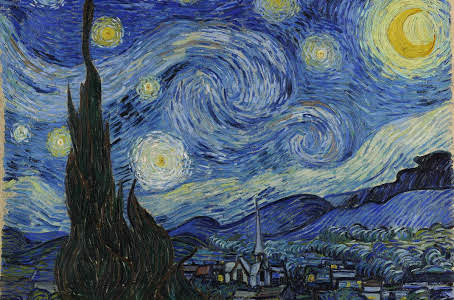

In [ ]:
content_image = load_image(content_img_path)
print(content_image.shape)
show_image(content_image)

Now lets load our content image and display it.

(1, 336, 512, 3)


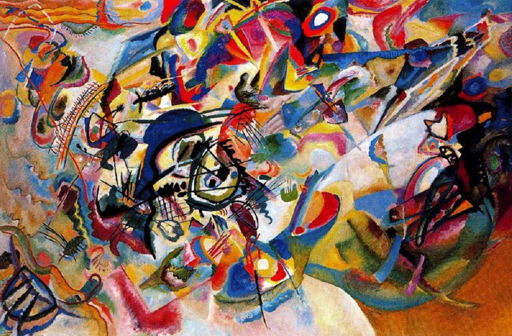

In [ ]:
style_image = load_image(style_img_path)
print(style_image.shape)
show_image(style_image)

Similarly load style image and display it.

In [ ]:
def stylized_model(model, layer_names):
    model.trainable=False
    outputs=[model.get_layer(name).output for name in layer_names]
    new_model=Model(inputs=model.input,outputs=outputs)
    return new_model

the above function creates a stylized model. Since we are not training our model so we set trainable to false. Our stylized model takes input as image and outputs the activations of layers which we will use to extract content and style from image.
This function takes:
- pretrained model which we will use to extract features from images (we are using vgg pretrained model as it was used in original implementation).
- layer names from which we want to extract features

In [ ]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Here we initiate pretrained vgg19 network (vgg network with 19 blocks) without its final classification dense layers as we only need feature extractor for this task and print its layers.

In [ ]:
# style and content layers
content_layers=['block5_conv2']

style_layers=['block1_conv1',
             'block2_conv1',
             'block3_conv1',
             'block4_conv1',
             'block5_conv1']

Lets define layers which from which we want to extract features for style and content images. We try to extract appearences of our style image from all scenarios extracted by conv nets, so we have used multiple blocks of conv layers to capture feature maps at different spatial scales.

- We have used higher conv layer as content layer because higher convolutional layers have learned complex and high-level features
- For style layers we have use various layers at different scale to capture feature maps at different spatial scales.

In [ ]:
content_model = stylized_model(vgg, content_layers)
style_model = stylized_model(vgg, style_layers)

Here we initiate two models with content layers (content_model) and style_layers (style_model) just to check how we are getting outputs from these models.

In [ ]:
content_outputs = content_model(content_image)
for layer_name, outputs in zip(content_layers, content_outputs):
    print(layer_name)
    print(outputs.shape)

block5_conv2
(18, 28, 512)


We get output from layer which we defined in `content_layers` list. The output is feature map spit out by conv layer (block5_conv2) of shape (18,28,512)

In [ ]:
style_outputs = style_model(style_image)
for layer_name,outputs in zip(style_layers, style_outputs):
    print(layer_name)
    print(outputs.shape)

block1_conv1
(1, 336, 512, 64)
block2_conv1
(1, 168, 256, 128)
block3_conv1
(1, 84, 128, 256)
block4_conv1
(1, 42, 64, 512)
block5_conv1
(1, 21, 32, 512)


Similarly we can check output feature maps from layers defined in `style_layers` list

In [ ]:
model = stylized_model(vgg, style_layers + content_layers)

Now lets create a model which we will be used for style transfer. We create a vgg model which outputs all feature maps from the layers defined in `style_layers` and `content_layers` when an image is passed through it.

In [ ]:
def get_output_dict(model, inputs):
    inputs = inputs*255.0
    preprocessed_input = vgg19.preprocess_input(inputs)
    style_length = len(style_layers)
    outputs = model(preprocessed_input)
    style_output,content_output = outputs[:style_length],outputs[style_length:]
    content_dict = {name:value for name,value in zip(content_layers,content_output)}
    style_dict = {name:value for name,value in zip(style_layers,style_output)}
    return {'content':content_dict,'style':style_dict}

The above function takes style transfer model and image as input and spits out output feature maps for content and style layers in a python dictionary.

This dictionary has 2 keys:

- *content* : has all feature maps for the image from content_layers
- *style* : has all feature maps for the image from style_layers

In [ ]:
results = get_output_dict(model, style_image)

print("Content Image output Feature maps: ")
for layer_name,output in sorted(results['content'].items()):
    print(layer_name)
    print(output.shape)

print("Style Image output Feature maps: ")
for layer_name,output in sorted(results['style'].items()):
    print(layer_name)
    print(output.shape)

Content Image output Feature maps: 
block5_conv2
(1, 21, 32, 512)
block1_conv1
(1, 336, 512, 64)
block2_conv1
(1, 168, 256, 128)
block3_conv1
(1, 84, 128, 256)
block4_conv1
(1, 42, 64, 512)
block5_conv1
(1, 21, 32, 512)


Here we can see how we are getting feature maps as outputs when we pass an image (in our case we have passed `style_image` to check how we are getting outputs in a dictionary

In [ ]:
content_targets = get_output_dict(model,content_image)['content']
style_targets = get_output_dict(model,style_image)['style']

In above lines we have extracted content feature maps from our content image and style feature maps from style image

### Loss Functions

In [ ]:
def content_loss(placeholder, content):
    return tf.reduce_mean(tf.square(placeholder - content))

In [ ]:
def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2],tf.float32)

In [ ]:
def style_loss(placeholder,style):
    s = gram_matrix(style)
    p = gram_matrix(placeholder)
    return tf.reduce_mean(tf.square(s-p))

The above three functions are used to calculate *content loss* and *style loss* from our images.

- Content Loss : It is defined as mean square error between two images. It denotes, how close pixels of two images are? You have already seen this loss function in regression. If two image are same there mse is zero. We are using `mse` because we want to calculate pixel level closeness of images the more they are close in terms of pixels the more the content of images matches, this way we can check, how close the contents of content image and output image are?

- Style loss uses gram matrix to calculate coorelation or similarity between feature maps of two images. The dot product tells us by what amount one vector goes in the direction of another, in more intitutive way it tells similarity between two vectors. The more similiar vectors are the less is angle between them also dot product is greater in this case. For calculating style loss we are using gram matrix which is dot product of all style features with one another. This helps to capture relationship between feature maps the more the dot product between them the more correlated they are and less the dot product the less correlated they are. This relation capture stats of patterns in activations of convnet which represent appereance of texture in high level. Using `mse` between gram matrix of two images helps us to find closeness of features (style and texture) between two images, this way we can check, how style of one image is similar to another?

In [ ]:
def loss_function(outputs, content_outputs, style_outputs, content_weight, style_weight):
    final_content = outputs['content']
    final_style = outputs['style']
    num_style_layers = len(style_layers)
    num_content_layers = len(content_layers)
    # content loss
    # adding content loss from all content_layers and taking its average also multiply with some weighting parameter
    c_loss = tf.add_n([content_loss(content_outputs[name], final_content[name]) for name in final_content.keys()])
    c_loss *= content_weight / num_content_layers
    # style loss
    # adding style loss from all style_layers and taking its average also multiply with some weighting parameter
    s_loss = tf.add_n([style_loss(style_outputs[name], final_style[name]) for name in final_style.keys()])
    s_loss *= style_weight / num_style_layers
    # adding up both content and style loss
    loss = c_loss + s_loss
    return loss

The above function is our loss function which merges style and content loss of our style image and content image respectively with the style and content loss of our target placeholder image. This placeholder image will be our final styled image which has content of content image and style of style image.

we are also using some weighting for content and style loss which controls how much style or content we want in our final image. These weights are hyperparameters which can be used to tune final output image.

In [ ]:
output_image = tf.Variable(content_image, dtype=tf.float32)

lets define our output image which we will optimize using loss defined above to create final style image. We simply copy contents of content image into it for faster convergence because content is already present in image, this way we get an appealing image in less number of optimzation epochs. We can also use a noise image from normal distribution for this task.

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Above we have defined our optimizer which will be used to optimize output image by decreasing loss value from loss function defined above.

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0, clip_value_max=1.0)

The above function make sure that our pixels of image are in range [0, 1]

### Optimize output image

In [ ]:
def loss_optimizer(image, optimizer, content_weight, style_weight, total_variation_weight):
    with tf.GradientTape() as tape:
        outputs = get_output_dict(model,image)
        loss = loss_function(outputs, content_targets, style_targets, content_weight, style_weight)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

We have defined our loss optimizer which uses an optimizer to decrease loss value. It takes image that we want to optimize and an optimizer for optimization as parameters.

The optimization of our loss function(style + content loss) led highly pixelated and noisy image to prevent this we introduced total variation loss. It act as regularizer which smoothens generated image and ensure spatial continuity(different views of an object are sufficiently similar after one view is learned)

The third parameter is weight for total variation loss which we can use as hyerparameter to tune final image

In this funtion we calculate gradients of loss with respect to image using `tape.gradient`. With these gradients we optimize our image using `optimizer.apply_gradients` method.

In [ ]:
total_variation_weight=0.0004
style_weight=1e-2
content_weight=1e4

above we have defined our weights for content, style and total variation loss. We can tune them and check their effects in final output image. Change them based on your taste of final image.

In [ ]:
epochs=10
steps_per_epoch=100

In [ ]:
start=time.time()
for i in range(epochs):
    print(f"Epoch: {i+1}")
    for j in tqdm(range(steps_per_epoch)):
        curr_loss = loss_optimizer(output_image, optimizer, content_weight, style_weight, total_variation_weight)
        # we can save image in every step here
        # current_image = array_to_img(output_image.numpy(), deprocessing=True)
        # current_image.save(f'progress/{i}_{j}_paint.jpg')
    print(f"Loss: {curr_loss}")
end=time.time()
print(f"Image successfully generated in {end-start:.1f} sec")

Epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [92426.03]
Epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [80979.35]
Epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [71440.695]
Epoch: 4


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [63540.566]
Epoch: 5


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [56953.465]
Epoch: 6


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [51328.133]
Epoch: 7


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [46451.465]
Epoch: 8


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [42256.164]
Epoch: 9


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [38632.875]
Epoch: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [35406.48]
Image successfully generated in 48.6 sec


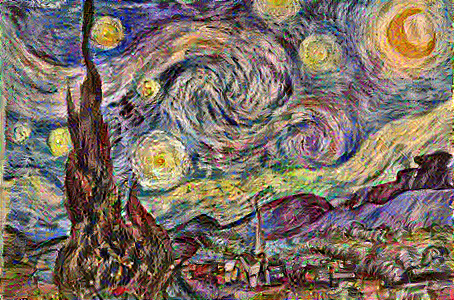

In [ ]:
show_image(output_image.numpy(), deprocessing=True)
final_image = array_to_img(output_image.numpy(), deprocessing=True)
final_image.save("kandinsky_starry.jpg")

This is interesting part because we are creating styled image here. we have defined number of epochs and steps per epochs, for every epoch we are calculating loss and optimizing our output image using adam optimizer.

Finally at last step we are saving output image into disk and its time to show off this to your friends.

Below is demo video showing style transfer in action.

<div>
  <a href="http://www.youtube.com/watch?v=weVfBfWVuZw"><img src='http://img.youtube.com/vi/weVfBfWVuZw/0.jpg' alt="Gatys style transfer"></a>
</div>

Play with it and share exciting results.

In next part we will be using another style transfer technique which will be 100 times faster than this and can be used to style videos too.

If someone want to try style transfer in video and images right now, I have created a [github repository](https://github.com/tarun-bisht/fast-style-transfer) for same purpose with instructions.

Thanks for reading till last. ✌✌✌

### References

- [Tensorflow Tutorials Keras Book](https://livebook.manning.com/book/deep-learning-with-python/chapter-8/76)
- [Tensorflow docs](https://www.tensorflow.org/tutorials/generative/style_transfer)
- [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)